In [1]:
import numpy as np

import boto3
import os
import cv2
import io

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from data_preparation import CreateDataset, encode_labels
from models import ViT
from trainer import evaluate_transformer_loss, evaluate_transformer_model, plot_losses

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import multiprocessing

# Determine the number of available CPU cores
num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
data = "ck"
# data = "fer2013"

In [4]:


def load_images_and_labels(bucket_name, folder_prefix):
    s3_client = boto3.client('s3')
    
    image_paths = []
    labels = []
    
    # List all objects within the folder prefix
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix)
    
    # Process each object (file) in the response
    for item in response.get('Contents', []):
        key = item['Key']
        
        # Skip directories (folders)
        if key.endswith('/'):
            continue
        
        # Extract the label from the key (assumes label is part of the path)
        label = key.split('/')[-2]  # This assumes the label is the parent directory of the image
        
        # Store the S3 path and corresponding label
        image_paths.append(f's3://{bucket_name}/{key}')
        labels.append(label)
    
    return image_paths, labels


In [5]:
bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [6]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [7]:
# Encode labels to integers
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [8]:
image_size = (224, 224)  # ViT requires 224x224 images

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    ])

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [9]:
model = ViT(num_labels=len(label_encoder.classes_)).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=1e-4)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=3):
    global best_val_loss, patience_counter
    best_val_loss = np.inf
    patience_counter = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            # Clean up GPU memory
            del images, labels, outputs, loss
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        avg_val_loss = evaluate_transformer_loss(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, val_losses

train_loss, val_loss = train_model(model,
                                   train_loader,
                                   val_loader,
                                   criterion,
                                   optimizer,
                                   device,
                                   epochs=500,
                                   patience=10)


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 1, Train Loss: 1.7306, Validation Loss: 1.4746


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 2, Train Loss: 1.3426, Validation Loss: 1.1248


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 3, Train Loss: 1.0194, Validation Loss: 0.8870


100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


Epoch 4, Train Loss: 0.8046, Validation Loss: 0.7359


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 5, Train Loss: 0.6386, Validation Loss: 0.5998


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 6, Train Loss: 0.5046, Validation Loss: 0.5166


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 7, Train Loss: 0.4286, Validation Loss: 0.7018


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 8, Train Loss: 0.3865, Validation Loss: 0.4440


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 9, Train Loss: 0.3160, Validation Loss: 0.4119


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 10, Train Loss: 0.2828, Validation Loss: 0.2943


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 11, Train Loss: 0.2180, Validation Loss: 0.3275


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 12, Train Loss: 0.1897, Validation Loss: 0.2362


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 13, Train Loss: 0.1766, Validation Loss: 0.2898


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 14, Train Loss: 0.1825, Validation Loss: 0.2883


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 15, Train Loss: 0.1425, Validation Loss: 0.2385


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 16, Train Loss: 0.1409, Validation Loss: 0.2440


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Epoch 17, Train Loss: 0.1103, Validation Loss: 0.1631


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 18, Train Loss: 0.0968, Validation Loss: 0.2041


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 19, Train Loss: 0.1045, Validation Loss: 0.1896


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 20, Train Loss: 0.0919, Validation Loss: 0.1417


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Epoch 21, Train Loss: 0.0917, Validation Loss: 0.2303


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Epoch 22, Train Loss: 0.0859, Validation Loss: 0.2470


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 23, Train Loss: 0.0950, Validation Loss: 0.3122


100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Epoch 24, Train Loss: 0.0888, Validation Loss: 0.2159


100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Epoch 25, Train Loss: 0.0867, Validation Loss: 0.1610


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 26, Train Loss: 0.0954, Validation Loss: 0.1441


100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Epoch 27, Train Loss: 0.1081, Validation Loss: 0.1836


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 28, Train Loss: 0.0922, Validation Loss: 0.1477


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 29, Train Loss: 0.0597, Validation Loss: 0.1178


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Epoch 30, Train Loss: 0.0603, Validation Loss: 0.2202


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 31, Train Loss: 0.0788, Validation Loss: 0.3213


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 32, Train Loss: 0.1188, Validation Loss: 0.1662


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 33, Train Loss: 0.0833, Validation Loss: 0.1518


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 34, Train Loss: 0.0598, Validation Loss: 0.1421


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Epoch 35, Train Loss: 0.0665, Validation Loss: 0.2206


100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Epoch 36, Train Loss: 0.0832, Validation Loss: 0.5083


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 37, Train Loss: 0.1551, Validation Loss: 0.1755


100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Epoch 38, Train Loss: 0.0636, Validation Loss: 0.1355


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 39, Train Loss: 0.0495, Validation Loss: 0.0918


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 40, Train Loss: 0.0340, Validation Loss: 0.1047


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 41, Train Loss: 0.0309, Validation Loss: 0.0986


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 42, Train Loss: 0.0283, Validation Loss: 0.1115


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 43, Train Loss: 0.0277, Validation Loss: 0.0630


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 44, Train Loss: 0.0260, Validation Loss: 0.1027


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 45, Train Loss: 0.0249, Validation Loss: 0.0884


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 46, Train Loss: 0.0251, Validation Loss: 0.0804


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 47, Train Loss: 0.0239, Validation Loss: 0.0735


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 48, Train Loss: 0.0225, Validation Loss: 0.0852


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 49, Train Loss: 0.0217, Validation Loss: 0.0474


100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Epoch 50, Train Loss: 0.0211, Validation Loss: 0.0720


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 51, Train Loss: 0.0203, Validation Loss: 0.0642


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 52, Train Loss: 0.0197, Validation Loss: 0.1004


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 53, Train Loss: 0.0192, Validation Loss: 0.0831


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch 54, Train Loss: 0.0186, Validation Loss: 0.1054


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Epoch 55, Train Loss: 0.0180, Validation Loss: 0.0919


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 56, Train Loss: 0.0176, Validation Loss: 0.0840


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 57, Train Loss: 0.0170, Validation Loss: 0.0784


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 58, Train Loss: 0.0167, Validation Loss: 0.0626


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch 59, Train Loss: 0.0161, Validation Loss: 0.0518
Early stopping triggered


In [11]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'vit_{data}_best_model.pt'
torch.save(model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

#os.remove(model_path)

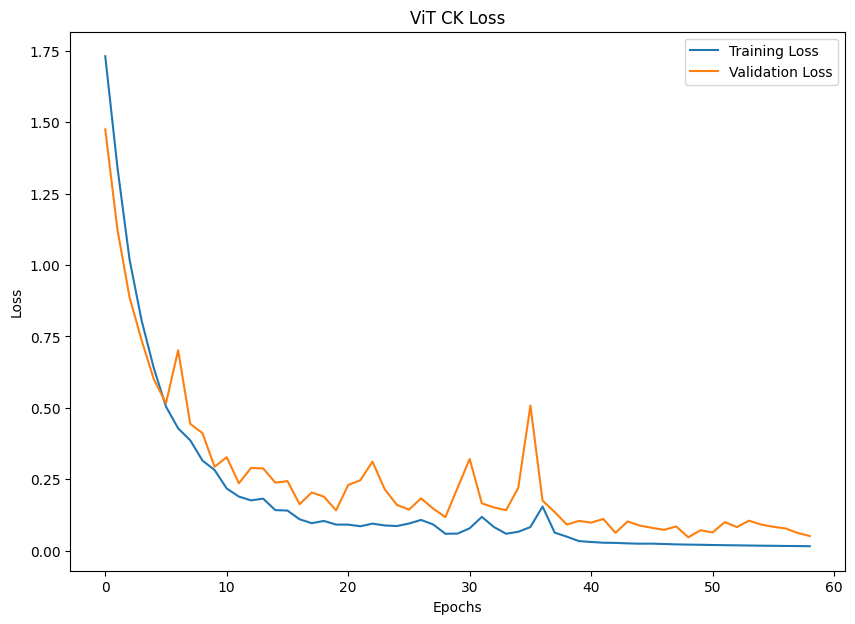

In [12]:
plot_losses(train_loss, val_loss, f'ViT {data.upper()} Loss')

In [13]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

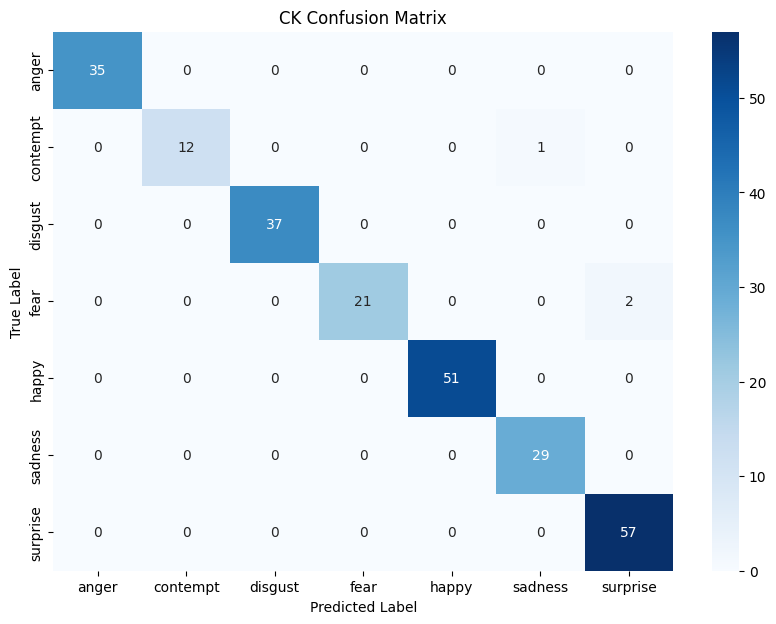

Test Accuracy: 0.9878
Precision: 0.9904
Recall: 0.9766
F1 Score: 0.9829
Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        35
    contempt       1.00      0.92      0.96        13
     disgust       1.00      1.00      1.00        37
        fear       1.00      0.91      0.95        23
       happy       1.00      1.00      1.00        51
     sadness       0.97      1.00      0.98        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.99       245
   macro avg       0.99      0.98      0.98       245
weighted avg       0.99      0.99      0.99       245



In [14]:
evaluate_transformer_model(model, 
                           test_loader, 
                           device, 
                           data, 
                           label_encoder=label_encoder)